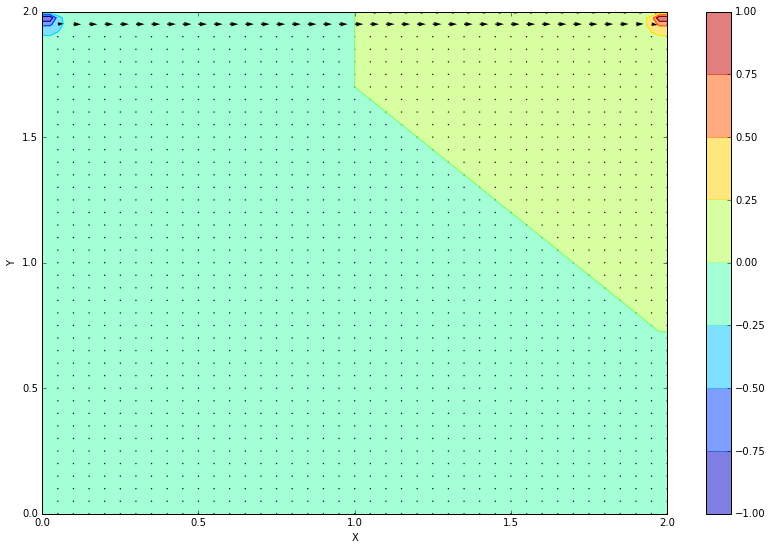

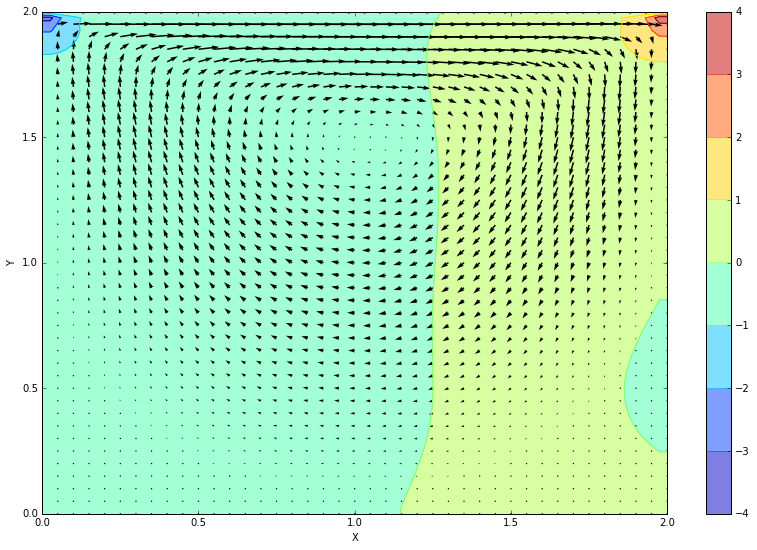

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numba import autojit
%matplotlib inline

def plot2D(X, Y, p):
    fig = plt.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    surf1 = ax.plot_surface(X, Y, p, rstride=1, cstride=1,
        cmap=cm.coolwarm, antialiased=False, linewidth=0)
    ax.set_xlim(0,2)
    ax.set_ylim(0,2)
    ax.view_init(30,225)
    
def poisson2d(u, v, p, dx, dy, dt, rho, nit):
    ufx = u[2:, 1:-1]
    ubx = u[:-2, 1:-1]
    ufy = u[1:-1, 2:]
    uby = u[1:-1, :-2]
    uc  = u[1:-1, 1:-1]

    vfx = v[2:, 1:-1]
    vbx = v[:-2, 1:-1]
    vfy = v[1:-1, 2:]
    vby = v[1:-1, :-2]
    vc  = v[1:-1, 1:-1]
    
#     poisson_brackets = ((ufx-ubx)/(2*dx)+(vfy-vby)/(2*dy))/dt -\
#         ((ufx-ubx)/(2*dx))**2 -\
#         2*(ufy-uby)/(2*dy)*(vfx-vbx)/(2*dx) -\
#         ((vfy-vby)/(2*dy))**2
    poisson_brackets = rho*(1/dt*((ufy-uby)/(2*dx)+(vfx-vbx)/(2*dy))-\
                           ((ufy-uby)/(2*dx))**2-\
                    2*((ufx-ubx)/(2*dy)*(vfy-vby)/(2*dx))-\
                        ((vfx-vbx)/(2*dy))**2)
    
    def iteration(p):
        pfx = p[2:, 1:-1]
        pbx = p[:-2, 1:-1]
        pfy = p[1:-1, 2:]
        pby = p[1:-1, :-2]
        pc  = p[1:-1, 1:-1]

        center_update = ((pfx+pbx)*dy**2+(pfy+pby)*dx**2)/(2*(dx**2+dy**2)) -\
            rho*dx**2*dy**2/(2*(dx**2+dy**2))*poisson_brackets
        p[1:-1,1:-1] = center_update
        #neumann boundary conditions on y
        p[:,-1] = p[:,-2]
        p[0,:] = p[1,:]
        #neumann boundary condition at bottom x
        p[:,0] = p[:,1]
        #dirichlet boundary on top x
        p[-1,:] = 0
    
        return p

    for q in range(nit):
        p = iteration(p)
    return p
   
def cavityFlow(u, v, p, dx, dy, dt, rho, nu, nt, nit):
    for n in range(nt):
        un, vn = u.copy(), v.copy()
        
        ufx = un[2:, 1:-1]
        ubx = un[:-2, 1:-1]
        ufy = un[1:-1, 2:]
        uby = un[1:-1, :-2]
        uc  = un[1:-1, 1:-1]

        vfx = vn[2:, 1:-1]
        vbx = vn[:-2, 1:-1]
        vfy = vn[1:-1, 2:]
        vby = vn[1:-1, :-2]
        vc  = vn[1:-1, 1:-1]
        
        p = poisson2d(u, v, p, dx, dy, dt, rho, nit)
        pfx = p[2:, 1:-1]
        pbx = p[:-2, 1:-1]
        pfy = p[1:-1, 2:]
        pby = p[1:-1, :-2]
        pc  = p[1:-1, 1:-1]
        u[1:-1, 1:-1] = uc - uc*dt/dx*(uc-uby)- vc*dt/dy*(uc-ubx) -\
            dt/(2*rho*dx)*(pfy-pby) + nu*(dt/dx**2*(ufy-2*uc+uby)+\
            (dt/dy**2*(ufx-2*uc+ubx)))
            
        v[1:-1, 1:-1] = vc - uc*dt/dx*(vc-vby)- vc*dt/dy*(vc-vbx) -\
            dt/(2*rho*dy)*(pfx-pbx) + nu*(dt/dx**2*(vfy-2*vc+vby)+\
            (dt/dy**2*(vfx-2*vc+vbx)))
        
        u[:,0] = u[:,0] = u[:,-1] = 0
        u[-1, :] = 1
        v[0,:] = v[-1,:] = v[:,0] = v[:,-1] = 0
    return u, v, p
        
def run(n=41, nt=500, nit=50, rho=1, nu = 0.1, dt = 1e-3):
    x, dx = np.linspace(0,2,n, retstep=True)
    y, dy = np.linspace(0,2,n, retstep = True)
    X,Y = np.meshgrid(x,y)

    u = np.zeros((n, n))
    v = np.zeros((n, n))
    p = np.zeros((n, n)) 
    u, v, p = cavityFlow(u, v, p, dx, dy, dt, rho, nu, nt, nit)
    
    fig, axes = plt.subplots(figsize=(14,9), dpi=100)
    cf = axes.contourf(X,Y,p,alpha=0.5)
    fig.colorbar(cf)
    axes.contour(X,Y,p)
    axes.quiver(X[::2,::2],Y[::2,::2], u[::2, ::2], v[::2, ::2])
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
run(n=81,nt=3)
run(n=81,nt=5000)